# 数据分析案例

In [2]:
import numpy as np
import pandas as pd

例1-----来自Bitly的USA.gov数据-----

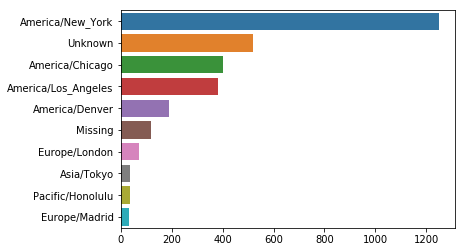

In [643]:
import json
path = 'E:/useFiles/datasets/bitly_usagov/example.txt'
records=[json.loads(line) for line in open(path)]
records[0]
# 想要知道该数据集中最常出现的是哪个时区（即tz字段）
time_zones=[rec['tz'] for rec in records if 'tz' in rec]
time_zones[:10]

# 使用collections.Counter对时区进行计数：
from collections import Counter
counts=Counter(time_zones)
counts.most_common(5)


# 用pandas对时区进行计数：
frame=pd.DataFrame(records)
# frame.info()
frame.tz[:5]
tz_counts=frame['tz'].value_counts()     # value_counts()自动倒序排序
tz_counts[:5]
# 用matplotlib可视化这个数据，fillna可以替换缺失值（NA），未知值（空字符串）可以通过布尔型数组索引加以替换
clean_tz=frame['tz'].fillna('Missing')
type(clean_tz)
# clean_tz.value_counts()['']
clean_tz[clean_tz=='']='Unknown'
tz_counts = clean_tz.value_counts()
import seaborn as sns
subset = tz_counts[:10]
sns.barplot(y=subset.index, x=subset.values)


In [644]:
# a字段含有执行URL短缩操作的浏览器、设备、应用程序的相关信息：
results=pd.Series([x.split()[0] for x in frame.a.dropna()])
results.value_counts()[:5]


Mozilla/5.0               2594
Mozilla/4.0                601
GoogleMaps/RochesterNY     121
Opera/9.80                  34
TEST_INTERNET_AGENT         24
dtype: int64

D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


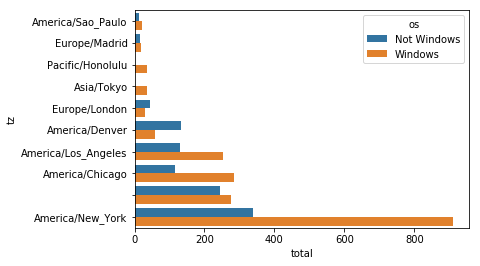

In [646]:
# 按Windows和非Windows用户对时区统计信息进行分解
# frame[frame['tz']=='Unknown']=''
cframe=frame[frame.a.notnull()]
cframe['os']=np.where(cframe['a'].str.contains('Windows'), 'Windows', 'Not Windows')     #np.where(condition, x, y)满足条件(condition)，输出x，不满足输出y。
cframe['os']
# 接下来就可以根据时区和新得到的操作系统列表对数据进行分组了：
by_tz_os = cframe.groupby(['tz', 'os'])
# 分组计数，类似于value_counts函数，可以用size来计算
agg_counts=by_tz_os.size().unstack().fillna(0)
# 选取最常出现的时区
# agg_counts.sum(axis=1).sort_values(ascending=False)[:10]
indexer=agg_counts.sum(1).argsort()
count_subset = agg_counts.take(indexer[-10:])
# pandas有一个简便方法nlargest:
agg_counts.sum(1).nlargest(10)

count_subset = count_subset.stack()     #堆叠DataFrame意味着移动最里面的列索引成为最里面的行索引
count_subset.name = 'total'
count_subset = count_subset.reset_index()     # count_subset由Series变成DataFrame
sns.barplot(x='total', y='tz', hue='os', data=count_subset)

# cframe.groupby(['os','tz']).size().unstack()


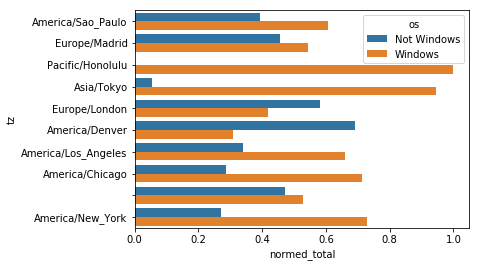

In [299]:
# Windows用户在每个tz分组中的相对比例
def norm_total(group):
    group['normed_total']=group.total/group.total.sum()
    return group
results=count_subset.groupby('tz').apply(norm_total)
# results=count_subset.groupby('tz').apply(lambda x:x.total/x.total.sum())
sns.barplot(x='normed_total', y='tz', hue='os', data=results)


In [152]:
# count_subset.total/count_subset.groupby('tz').total.transform('sum')

例2-----MovieLens 1M数据集-----

In [332]:
pd.options.display.max_rows=10

unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users=pd.read_table('E:/useFiles/datasets/movielens/users.dat', sep='::', header=None, names=unames)
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('E:/useFiles/datasets/movielens/ratings.dat', sep='::', header=None, names=rnames)
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('E:/useFiles/datasets/movielens/movies.dat', sep='::', header=None, names=mnames)

# 我们先用pandas的merge函数将ratings跟users合并到一起，然后再将movies也合并进去。pandas会根据列名的重叠情况推断出哪些列是合并（或连接）键
data = pd.merge(pd.merge(ratings, users), movies)

# 按性别计算每部电影的平均得分：
mean_ratings=data.pivot_table('rating', index='title',columns='gender', aggfunc='mean')
# 过滤掉评分数据不够250条的电影
ratings_by_title=data.groupby('title').size()
active_titles=ratings_by_title.index[ratings_by_title >= 250]     #电影名
mean_ratings=mean_ratings.loc[active_titles]

# 为了了解女性观众最喜欢的电影，可以对F列降序排列
top_female_ratings=mean_ratings.sort_values(by='F', ascending=False)
top_female_ratings


D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
...,...,...
"Avengers, The (1998)",1.915254,2.017467
Speed 2: Cruise Control (1997),1.906667,1.863014
Rocky V (1990),1.878788,2.132780


In [325]:
# 找出男性和女性观众分歧最大的电影
mean_ratings['diff']=(mean_ratings['M']-mean_ratings['F']).abs()
mean_ratings.sort_values(by='diff', ascending=False)

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,0.830782
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Jumpin' Jack Flash (1986),3.254717,2.578358,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
...,...,...,...
Robin Hood: Prince of Thieves (1991),3.161290,3.163347,0.002056
Trainspotting (1996),3.958974,3.960432,0.001457
Jerry Maguire (1996),3.758315,3.759424,0.001109


In [354]:
# 找出分歧最大的电影
rating_std_by_title = data.groupby('title')['rating'].std()
rating_std_by_title = rating_std_by_title.loc[active_titles]
rating_std_by_title.sort_values(ascending=False).iloc[:1]

title
Dumb & Dumber (1994)    1.321333
Name: rating, dtype: float64

例3-----1880-2010年间全美婴儿姓名-----

In [359]:
years=range(1880,2011)
columns = ['name', 'sex', 'births']
pieces = []
for year in years:
    path = 'E:/useFiles/datasets/babynames/yob%d.txt' % year
    frame=pd.read_csv(path, names=columns)
    frame['year']=year
    pieces.append(frame)
names=pd.concat(pieces, ignore_index=True)     # pd.concat([df1, df2])
names[:3]

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880


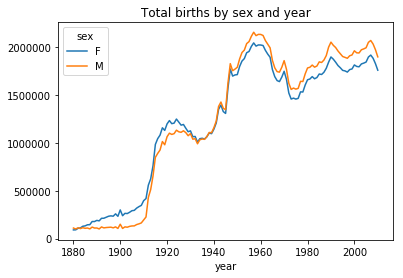

In [369]:
total_births=names.pivot_table('births', index='year', columns='sex', aggfunc=sum)
total_births.tail()
total_births.plot(title='Total births by sex and year')

In [370]:
def add_prop(group):
    group['prop']=group.births/group.births.sum()
    return group
names=names.groupby(['year', 'sex']).apply(add_prop)
names
# names.groupby(['year', 'sex']).prop.sum()

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


In [382]:
# 取每对sex/year组合的前1000个名字
grouped=names.groupby(['year', 'sex'])
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]
top1000=grouped.apply(get_top1000)
top1000.reset_index(inplace=True, drop=True)
top1000

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


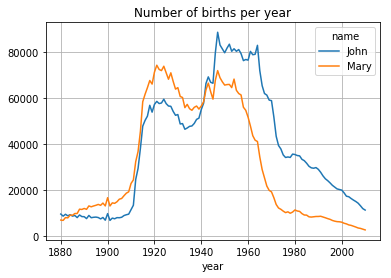

In [400]:
boys=top1000[top1000.sex=='M']
girls=top1000[top1000.sex=='F']
total_births=top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)
subset=total_births[['John', 'Mary']]
subset.plot( figsize=(6, 4), grid=True, title="Number of births per year")

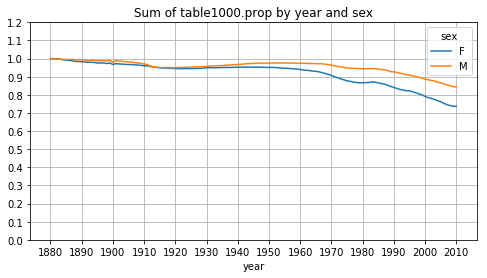

In [413]:
# 评估命名多样性的增长
# 计算最流行的1000个名字所占的比例
table=top1000.pivot_table('prop', index='year', columns='sex', aggfunc=sum)
table.plot(title='Sum of table1000.prop by year and sex', yticks=np.linspace(0, 1.2, 13), xticks=range(1880,2020,10), figsize=(8,4),grid=True)

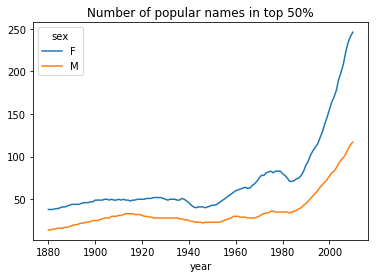

In [437]:
# 计算占总出生人数前50%的不同名字的数量，这里只考虑2010年男孩的名字
df = boys[boys.year == 2010]
# 先计算prop的累计和cumsum，然后再通过searchsorted方法找出0.5应该被插入在哪个位置才能保证不破坏顺序
prop_cumsum=df.sort_values(by='prop', ascending=False).prop.cumsum()
prop_cumsum.values.searchsorted(0.5)     #由于数组索引是从0开始的，因此我们要给这个结果加1，即最终结果为117


# 现在就可以对所有year/sex组合执行这个计算
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().values.searchsorted(q)+1
diversity=top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity=diversity.unstack('sex')
diversity.plot(title="Number of popular names in top 50%")


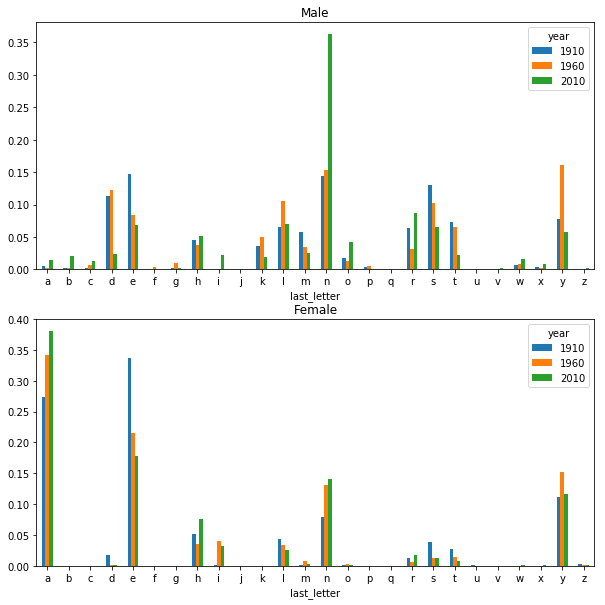

In [507]:
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'
table = names.pivot_table('births', index=last_letters, columns=['sex', 'year'], aggfunc=sum)
# table.stack('sex')
# 选出具有一定代表性的三年
subtable=table.reindex(columns=[1910, 1960, 2010], level='year')
letter_prop=subtable/subtable.sum()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female')

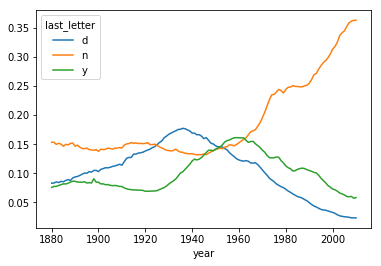

In [486]:
# 回到之前创建的那个完整表，按年度和性别对其进行规范化处理，并在男孩名字中选取几个字母，最后进行转置以便将各个列做成一个时间序列
letter_prop = table / table.sum()
letter_prop
dny_ts=letter_prop.loc[['d', 'n', 'y'], 'M'].T 
dny_ts.plot()

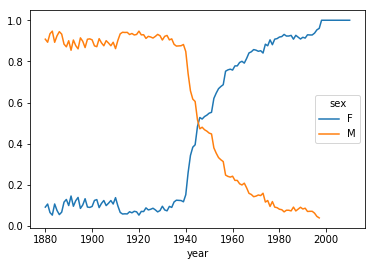

In [511]:
# 变成女孩名字的男孩名字
# 回到top1000数据集，找出其中以‘lesl’开头的一组名字
all_names=pd.Series(top1000.name.unique())
lesley_like=all_names[all_names.str.lower().str.contains('lesl')]
filtered=top1000[top1000.name.isin(lesley_like)]
# filtered.groupby('name').births.sum()
table=filtered.pivot_table('births', index='year', columns='sex', aggfunc=sum)
table=table.div(table.sum(1), axis=0)      # 每一行F或M除以（F+M）
table.plot()

例4-----USDA食品数据库-----

In [561]:
import json
db=json.load(open('E:/useFiles/datasets/usda_food/database.json'))
type(db[0])
db[0]['nutrients']

[{'value': 25.18,
  'units': 'g',
  'description': 'Protein',
  'group': 'Composition'},
 {'value': 29.2,
  'units': 'g',
  'description': 'Total lipid (fat)',
  'group': 'Composition'},
 {'value': 3.06,
  'units': 'g',
  'description': 'Carbohydrate, by difference',
  'group': 'Composition'},
 {'value': 3.28, 'units': 'g', 'description': 'Ash', 'group': 'Other'},
 {'value': 376.0, 'units': 'kcal', 'description': 'Energy', 'group': 'Energy'},
 {'value': 39.28,
  'units': 'g',
  'description': 'Water',
  'group': 'Composition'},
 {'value': 1573.0, 'units': 'kJ', 'description': 'Energy', 'group': 'Energy'},
 {'value': 0.0,
  'units': 'g',
  'description': 'Fiber, total dietary',
  'group': 'Composition'},
 {'value': 673.0,
  'units': 'mg',
  'description': 'Calcium, Ca',
  'group': 'Elements'},
 {'value': 0.64,
  'units': 'mg',
  'description': 'Iron, Fe',
  'group': 'Elements'},
 {'value': 22.0,
  'units': 'mg',
  'description': 'Magnesium, Mg',
  'group': 'Elements'},
 {'value': 490.0,

In [538]:
db[0]['nutrients'][:2]
pd.DataFrame(db[0]['nutrients'])

,description,group,units,value
0,Protein,Composition,g,25.180
1,Total lipid (fat),Composition,g,29.200
2,"Carbohydrate, by difference",Composition,g,3.060
3,Ash,Other,g,3.280
4,Energy,Energy,kcal,376.000
...,...,...,...,...
157,Serine,Amino Acids,g,1.472
158,Cholesterol,Other,mg,93.000
159,"Fatty acids, total saturated",Other,g,18.584
160,"Fatty acids, total monounsaturated",Other,g,8.275


In [566]:
info_keys = ['description', 'group', 'id', 'manufacturer']
info=pd.DataFrame(db, columns=info_keys)
info[:3]
# info.group.value_counts()[:10]

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,


In [563]:
# 对全部营养数据做一些分析
# columns = ['id', 'value', 'description', 'group', 'units']
pieces = []
for rec in db:
    frame=pd.DataFrame(rec['nutrients'])
    frame['id']=rec['id']
    pieces.append(frame)
nutrients=pd.concat(pieces, ignore_index=True) 
nutrients[:3]

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008


In [577]:
nutrients.duplicated().sum()
nutrients=nutrients.drop_duplicates()     #删除重复行
# 由于info和nutrients对象中都有"group"和"description"，我们需要对它们进行重命名
col_mapping = {'description' : 'food', 'group' : 'fgroup'}
info = info.rename(columns=col_mapping, copy=False)
col_mapping = {'description' : 'nutrient', 'group' : 'nutgroup'}
nutrients = nutrients.rename(columns=col_mapping, copy=False)
# 将info跟nutrients合并:
ndata=pd.merge(nutrients, info, on='id', how='outer')
ndata[:3]

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.18,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.20,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.06,1008,"Cheese, caraway",Dairy and Egg Products,


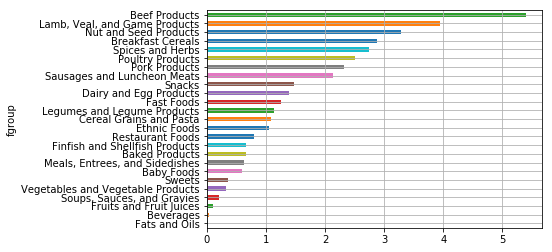

In [593]:
# 根据食物分类和营养类型画出一张中位值图
result=ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)
result['Zinc, Zn'].sort_values().plot(kind='barh', grid=True)
# result['Zinc, Zn']['Beef Products']

In [611]:
# 各营养成分最为丰富的食物
by_nutrient=ndata.groupby(['nutgroup', 'nutrient'])
get_maximum= lambda x:x.loc[x.value.idxmax()]     #获取Series的最大值的索引值
get_minimum= lambda x:x.loc[x.value.idxmin()]     #获取Series的最大值的索引值
max_foods =by_nutrient.apply(get_maximum)[['value','food']]

# max_foods.food = max_foods.food.str[:50]
max_foods
# max_foods.loc['Amino Acids']['food']

value  \
nutgroup    nutrient                                 
Amino Acids Alanine                          8.009   
            Arginine                         7.436   
            Aspartic acid                   10.203   
            Cystine                          1.307   
            Glutamic acid                   17.452   
...                                            ...   
Vitamins    Vitamin D2 (ergocalciferol)     28.100   
            Vitamin D3 (cholecalciferol)    27.400   
            Vitamin E (alpha-tocopherol)   149.400   
            Vitamin E, added                46.550   
            Vitamin K (phylloquinone)     1714.500   

                                                                                       food  
nutgroup    nutrient                                                                         
Amino Acids Alanine                                       Gelatins, dry powder, unsweetened  
            Arginine                                           Seeds, sesame flour, low-fat  
            Aspartic acid                                               Soy protein isolate  
            Cystine                            Seeds, cottonseed flour, low fat (glandless)  
            Glutamic acid                                               Soy protein isolate  
...                                                                                     ...  
Vitamins    Vitamin D2 (ergocalciferol)                             Mushrooms, maitake, raw  
            Vitamin D3 (cholecalciferol)                      Fish, halibut, Greenland, raw  
            Vitamin E (alpha-tocopherol)                                    Oil, wheat germ  
            Vitamin E, added              Cereals ready-to-eat, GENERAL MILLS, Multi-Gra...  
            Vitamin K (phylloquinone)                                  Spices, sage, ground  

[94 rows x 2 columns]

例5-----2012联邦选举委员会数据库-----

In [618]:
fec=pd.read_csv('E:/useFiles/datasets/fec/P00000001-ALL.csv')
# fec.info()
fec.iloc[:3]

D:\Program\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073


In [622]:
# 获取全部的候选人名单
unique_cands=fec.cand_nm.unique()
# unique_cands[2]
# 使用字典指明候选人的党派信息
parties = {'Bachmann, Michelle': 'Republican',
'Cain, Herman': 'Republican',
'Gingrich, Newt': 'Republican',
'Huntsman, Jon': 'Republican',
'Johnson, Gary Earl': 'Republican',
'McCotter, Thaddeus G': 'Republican',
'Obama, Barack': 'Democrat',
'Paul, Ron': 'Republican',
'Pawlenty, Timothy': 'Republican',
'Perry, Rick': 'Republican',
"Roemer, Charles E. 'Buddy' III": 'Republican',
'Romney, Mitt': 'Republican',
'Santorum, Rick': 'Republican'}
fec['party']=fec.cand_nm.map(parties)
# fec['party'].value_counts()

pandas.core.series.Series

In [658]:
# 该数据既包括赞助也包括退款（负的出资额）：
(fec.contb_receipt_amt > 0).value_counts()
# 限定只有正的出资额
fec=fec[fec.contb_receipt_amt > 0]

# 只包含针对Barack Obama和Mitt Romney的竞选活动的赞助信息：
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack','Romney, Mitt'])]

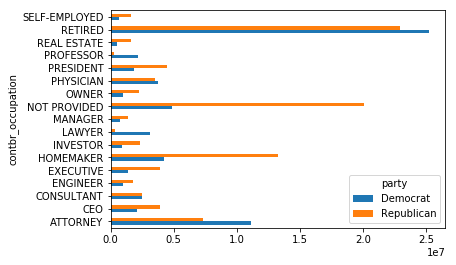

In [639]:
# 根据职业和雇主统计赞助信息
fec.contbr_occupation.value_counts()[:10]

# 将一个职业信息映射到另一个，这里巧妙地利用了dict.get，它允许没有映射关系的职业也能“通过”
occ_mapping = {
'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
'INFORMATION REQUESTED' : 'NOT PROVIDED',
'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
'C.E.O.': 'CEO'}
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation=fec.contbr_occupation.map(f)
# 对雇主信息也进行同样的处理
emp_mapping = {
'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
'INFORMATION REQUESTED' : 'NOT PROVIDED',
'SELF' : 'SELF-EMPLOYED',
'SELF EMPLOYED' : 'SELF-EMPLOYED',}
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

# 根据党派和职业对数据进行聚合，然后过滤掉总出资额不足200万美元的数据
by_occupation=fec.pivot_table('contb_receipt_amt', index='contbr_occupation', columns='party', aggfunc=sum)
# print(by_occupation[:5])
# by_occupation[:5].sum(axis=1)
over_2mm=by_occupation[by_occupation.sum(axis=1) > 2000000]
over_2mm.plot(kind='barh')

In [668]:
# 对Obama和Romney总出资额最高的职业和企业
# fec_mrbo.pivot_table('contb_receipt_amt', index=['contbr_occupation', 'contbr_employer'], columns='cand_nm', aggfunc=sum)
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.nlargest(n)     #相当于df.sort_values(columns, ascending=False).head(n)
grouped = fec_mrbo.groupby('cand_nm')
# 最高5职业：
grouped.apply(get_top_amounts, 'contbr_occupation')
# 最高5企业：
grouped.apply(get_top_amounts, 'contbr_employer')

cand_nm        contbr_employer
Obama, Barack  RETIRED            22694358.85
               SELF-EMPLOYED      18626807.16
               NOT EMPLOYED        8586308.70
               NOT PROVIDED        5053480.37
               HOMEMAKER           2605408.54
Romney, Mitt   NOT PROVIDED       12059527.24
               RETIRED            11506225.71
               HOMEMAKER           8147196.22
               SELF-EMPLOYED       7414115.22
               STUDENT              496490.94
Name: contb_receipt_amt, dtype: float64

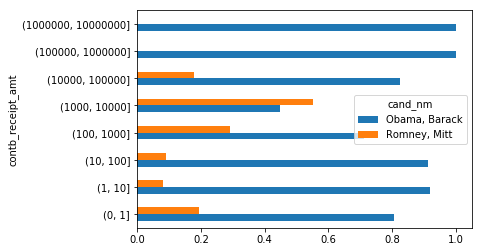

In [686]:
# 对出资额分组：利用cut函数根据出资额的大小将数据离散化到多个面元中
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)

# 根据候选人姓名以及面元标签对奥巴马和罗姆尼数据进行分组(求得区间总人数)：
grouped=fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

# 对出资额求和并在面元内规格化:
bucket_sums=grouped.contb_receipt_amt.sum().unstack(0)     #求得区间总金额
normed_sums=bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums.plot(kind='barh')

In [698]:
# 根据州统计赞助信息
grouped=fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals=grouped.contb_receipt_amt.sum().unstack(0).fillna(0)     
#堆叠(stack)DataFrame意味着移动最里面的列索引成为最里面的行索引；反向操作称之为取消堆叠(unstack)，意味着将最里面的行索引移动为最里面的列索引
totals[totals.sum(1) > 10000000]

# 对各行除以总赞助额，得到各候选人在各州的总赞助额比例：
totals.div(totals.sum(1), axis=0)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AA,0.997612,0.002388
AB,1.000000,0.000000
AE,0.883257,0.116743
AK,0.765778,0.234222
AL,0.507390,0.492610
...,...,...
WI,0.806982,0.193018
WV,0.571700,0.428300
WY,0.434456,0.565544
